In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from implementations import *

%load_ext autoreload
%autoreload 2

# **Load and clean the training data**

We load the training data.

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


For each feature, we clean the data so the values make more sense

In [1]:
#TODO : clean the data by calling the associated function in the implementations.py

We then clean the data by : 
- removing the nan values by the mean of the rest of the feature
- removing the features where the variance is zero since they are constants for all samples
- remove the 8 first features as the appear weird in the task of predicting a heart attack

In [4]:
x_train, zero_var_features = gen_clean(x_train)
print(f"The data has now {x_train.shape[1]} features !")

The data has now 306 features !


# PCA algorithm implementation

In [5]:
pca_indices, idx = pca(x_train)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 132 first most influent features given by pca_indices


In [6]:
x_train_pca = x_train[:, pca_indices]
x_train_pca = x_train_pca[:, :(idx + 1)]
print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 133 features


# Linear regression using stochastic gradient descent

We train our model using linear regression using SGD with mean-square error.

First, we separate our data in a training set(70%) and testing set(30%).

In [7]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.7)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (229694, 133) ; tx_te shape : (98441, 133)
       y_tr : (229694,)     ;        y_te : (98441,)


Now we build our models for linear regression using SGD

In [8]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 134 features !


## Training 

Here we train our model using SGD with MSE

In [9]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.009

start_time = datetime.datetime.now()
w, loss = mean_squared_error_sgd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 86.701844 seconds


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [10]:
pred_data = np.dot(tx, w)

pred_data[pred_data > 0] = 1
pred_data[pred_data < 0] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 88.25437320957448%
Precision: 19.702934860415176%
Recall : 10.89721383678923%
F1-score : 14.033075231813402%


Now we compute some metrics for our test data (40% of the total data)

In [11]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > 0] = 1
pred_test[pred_test < 0] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 88.17972186385754%
Precision: 20.493827160493826%
Recall : 11.35948905109489%
F1-score : 14.616965071910773%


### Feature analysis

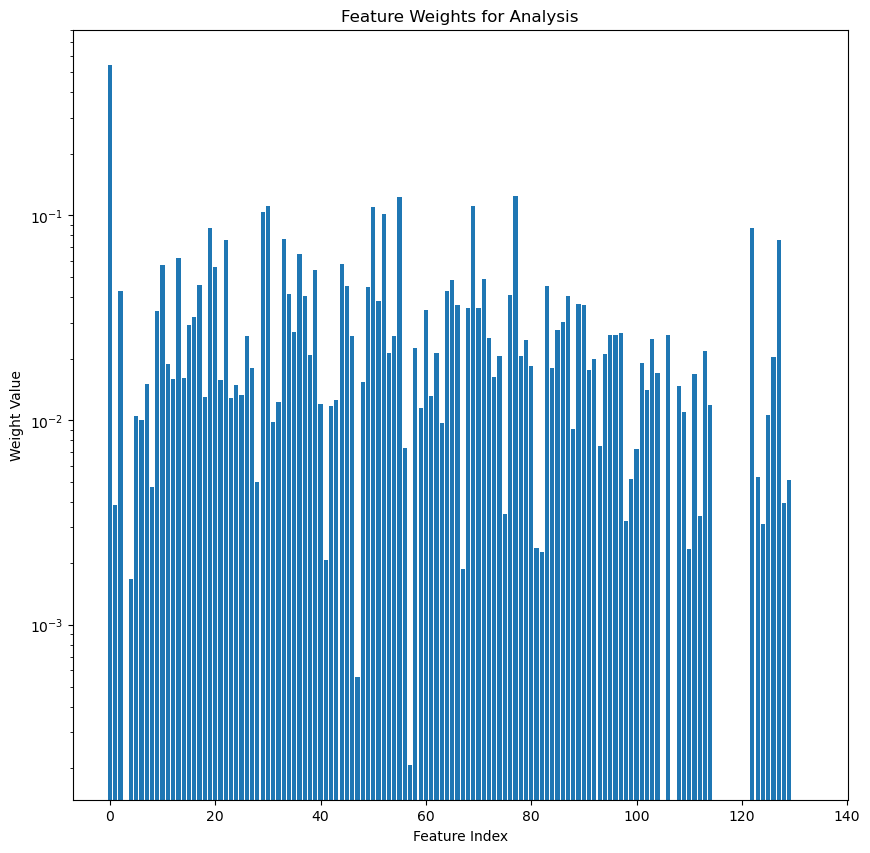

In [12]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# Prediction on test data

In [19]:
start_time = datetime.datetime.now()

data_te = np.ones(x_test.shape)

for i in range(data_te.shape[1]):
    d, _ = standardize_clean(x_test[:, i])
    data_te[:, i] = d
    
data_var_te = data_te[:, zero_var_features]
data_var_te = np.squeeze(data_var_te, axis = 1)
data_cleaned_te = data_var_te[:, 9:]

data_test = data_cleaned_te[:, pca_indices]
data_test = data_test[:, :(idx + 1)]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 1.955108 seconds


In [20]:
tx_te = np.c_[np.ones(data_test.shape[0]), data_test]
print(tx_te.shape)

(109379, 134)


In [21]:
y_te = np.dot(tx_te, w)
print(y_te.shape)

(109379,)


In [23]:
pred_te = y_te

pred_te[pred_te > 0] = 1
pred_te[pred_te < 0] = -1

indices_one = np.where(pred_te == 1)

In [24]:
create_csv_submission(test_ids, pred_te, "../data/sgd_reg.csv")